# 大規模データに対するクラスタリング: Teradata編

## (Optional) teradatamlの紹介

In [25]:
from teradataml import DataFrame, in_schema, create_context, remove_context, to_numeric

In [26]:
# whether using vpn or connect it via ssh-tunnelling
isSSHTunnel = False

In [27]:
if isSSHTunnel:
    server = SSHTunnelForwarder("suzuki-A-Yokohama",
                                remote_bind_address=("172.17.0.139", 1025),
                                local_bind_address=("localhost", 1025))
    server.start()
    con = create_context(host="localhost",
                         username="suzukiuser",
                         password="suzukiuser")

else:
    con = create_context(host = "172.17.0.139",
                     username="suzukiuser",
                     password="suzukiuser")

In [29]:
# Pulse Secureを使った上で、ssh-tunnellingを使うと、3秒くらいかかる。赤坂だと2.3秒くらい。
# 他方、OpenVPNだと0.6秒程度。
# OpenVPNを使ったほうが速いが、OpenVPNは接続が不安定であることがネック。

DataFrame("tdsuzuki.CAN_103_486_CAR1V21_HDD_1") # or DataFrame.from_table("demo.iris")

                  carid                 starttime     times               feature  val
0  021                   201604091141              1.496769  1AF67                 0.0
1  021                   201604091141              1.496769  1AF51                 0.0
2  021                   201604091141              1.496769  1AF52                 0.0
3  021                   201604091141              1.496769  1AF53                 0.0
4  021                   201604091141              1.496769  1AF23                 0.0
5  021                   201604091141              1.496769  1AF25                 0.0
6  021                   201604091141              1.496769  1AF47                -8.0
7  021                   201604091141              1.496769  1AF50                 0.0
8  021                   201604091141              1.496518  11407                 0.0
9  021                   201604091141              1.496518  11405                 0.0

In [31]:
DataFrame("tdsuzuki.CAN_103_486_CAR1V21_HDD_1", index_label="times")

                         carid                 starttime               feature  val
times                                                                              
1.496769  021                   201604091141              1AF67                 0.0
1.496769  021                   201604091141              1AF51                 0.0
1.496769  021                   201604091141              1AF52                 0.0
1.496769  021                   201604091141              1AF53                 0.0
1.496769  021                   201604091141              1AF23                 0.0
1.496769  021                   201604091141              1AF25                 0.0
1.496769  021                   201604091141              1AF47                -8.0
1.496769  021                   201604091141              1AF50                 0.0
1.496518  021                   201604091141              11407                 0.0
1.496518  021                   201604091141              11405             

In [32]:
df = DataFrame("tdsuzuki.CAN_103_486_CAR1V21_HDD_1")

In [34]:
df.groupby("feature").agg({"val":std()})

NameError: name 'np' is not defined

## 大データでのクラスタリング

### クラスタリング処理の流れ

- 1. 使用する変数を選択
    - 全く変化していない変数を除去
    - 定性的に選択
- 2. アップサンプリング(線形補間を使用)で時間インデックスを作成。トランザクションデータを時系列データとする。
- 3. 使用する変数を選択(時系列データとなったことで、以下が可能になる。)
    - 相関係数の高いペアを削除
    - 周期的に変動しているダミー変数を削除
- 4. ダウンサンプリング(平均、最大値、最小値、パーセンタイルを使用)で集約
    - 集約の方法は、VIN単位、時間単位、VIN×時間単位など
- 5. 使用するクラスター数(ハイパーパラメータ)と変数を決定
- 6. クラスタリングを実行
- 7. クラスターを解釈

### 使用する変数の選択

#### 全く変化していない変数を除去

In [35]:
# data_table = "tdsuzuki.CAN_103_486_CAR1V21_HDD_1_001" # large datatable
data_table = "tdsuzuki.CAN_For_Eval" # toysample for coding
interim_intp_table = "tdsuzuki.INTERIM_INTERPOLATED" # 中間データ用のテーブル(線形補間後)

In [36]:
import pandas as pd
from sqlalchemy import create_engine

In [37]:
host = "172.17.0.139" # sshで、サーバーの1025ポートをlocalhostの1025ポートにポートフォワーディングしている前提
user = "suzukiuser"
pasw = "suzukiuser"
engine = create_engine('teradata://'+ user +':' + pasw + '@'+ host + ':1025/')

In [24]:
# pd.read_sql_queryは引数のquery文字列内に日本語を使用できる。
# (pd.read_sqlは、引数にqueryの他、テーブル名も使用できるが、引数の文字列内に日本語を使用できない。)
pd.read_sql_query("""select top 5 * from {table};""".format(table=data_table),
           engine)

DatabaseError: (teradata.api.DatabaseError) (434, '[HY000] [Teradata][WSock32 DLL] (434) WSA E TimedOut: No response received when attempting to connect to the Teradata server') (Background on this error at: http://sqlalche.me/e/4xp6)

In [261]:
# 各featureのn_unique(値の種類の数)を確認
df_nunique = pd.read_sql_query("""
    select feature, count(distinct(val)) as nunique
    from {table}
    group by feature;
""".format(table=data_table),
                        engine)

In [262]:
df_nunique.head()

,feature,nunique
0,3BA12,1.0
1,31007,1.0
2,3C112,2.0
3,3D077,1.0
4,3D052,1.0


In [263]:
# 値の種類が2に満たないセンサーについては捨てる
feature_selected = df_nunique.loc[df_nunique["nunique"] >= 2, "feature"].to_list()

In [264]:
len(feature_selected)

106

In [265]:
sorted(feature_selected)[:5]

['0FA37', '0FA57', '11451', '11467', '11913']

In [121]:
# No Spool space errorでSQLが回らないので、暫定的に。
# Vehicle Speed, Accelerator actual position, Slope Value, Steering wheel absolute angle,
# Brake Stroke sensor value
feature_selected_mini = ['11947', '12217', '1EF37', '1EF61', '31417']

#### 定性的に選択

今回はあまり物性的な意味合いを考えず、数学的にクラスタリングを行うという立場にたち、ここでは定性的な理由で変数を除去しない。  
多くのプロジェクトでは、ここで興味のある事項に関係する変数のみを選択する。(例えば、加速度、速度のみに関係するセンサーのみ使用、など)

### アップサンプリング(線形補間を使用)で時間インデックスを作成。トランザクションデータを時系列データとする。

#### 時系列データとトランザクションデータとマスタデータ

- 時系列データとは、時間経過に従って計測されるデータポイント列であり、<font color=red>**一定の時間間隔で測定**</font>されることが特徴である。  
- その意味で、今回のセンサーデータは、タイムスタンプはついているものの、"一定の時間間隔"を満たしていないので、まだ時系列データではない。
- 今回のセンサーデータに強いて名前をつけるなら、トランザクションデータといえる。

- 「いつ」 「誰が」 「何を」 「誰に」 「どうした」というタイプの情報は、**トランザクションデータ**と呼ばれることがある。  
- トランザクションデータは、**マスタデータ**とセットで考えられることが多い。  
- マスタデータとは、トランザクションデータにおける「誰が」 「何を」 「誰に」にあたる部分、すなわち主語や目的語にあたる部分を説明するデータである。  

例えば、ある販売店のデータベースを考えると、以下のようになるだろう。
- トランザクションデータ: いつ、何の商品を、どの顧客に販売したかなどの取引履歴、
- マスタデータ: 商品や顧客のデータである。

**質問1**: ワランティデータは、時系列データだろうか？トランザクションデータだろうか？マスタデータだろうか？  
**質問2**: FTIRデータは、時系列データだろうか？トランザクションデータだろうか？マスタデータだろうか？  
**質問3**: 毎月のワランティ件数データは、時系列データだろうか？トランザクションデータだろうか？マスタデータだろうか？

#### アップサンプリングとダウンサンプリング

- ある時系列データに対して、時間間隔をより細かく取ってデータを作り直すことを**アップサンプリング**、時間間隔をより粗く取ってデータを作り直すことを**ダウンサンプリング**と呼ぶ。
- アップサンプリングの場合、値の作成方法としては、線形補間、スプライン補間、モデルによる予測の他、最も近い値を取る、直前の値を取る、直後の値を取る、などがある。すなわち"**補間(filling)**"的な手法が候補となる。もともとのデータは削除されないため、データの情報は減らない。
- ダウンサンプリングの場合、値の作成方法としては、平均や中央値を取る、最大値や最小値を取る、最初の値や最後の値を取る、などがある。すなわち"**集約(aggregation)**"的な手法が候補となる。データ数が減少するため、データの情報は減少する。
- 複数の値を取ってダウンサンプリング/アップサンプリングを行うこともある。その場合、項目数が増える。例えば、3軸の速度をダウンサンプリングするときに、平均値だけでなく最大値も取った場合、項目数は2倍となり、6つになる。

今回のセンサーデータは厳密には時系列データではなくトランザクションデータなのだが、各センサーとも、各々一定の周期でデータが記録されている様子がわかる。以下を参照。

##### センサーのサンプリングレートの調査

###### 全ての特徴量

In [97]:
# 各featureの時間間隔の平均値と中央値を確認
df_time_diff = pd.read_sql_query("""
    with t_timediff as (
        select carid
            ,feature
            ,starttime
            ,times
            ,lag(times) over(partition by carid, feature, starttime order by times) as prev_times
            ,cast(times - prev_times as real) as time_diff
        from {table}
        )
    
    select feature
        , avg(time_diff) as avg_time_diff
        , median(time_diff) as med_time_diff
    from t_timediff
    group by feature;
""".format(table=data_table),
                        engine)

In [98]:
with pd.option_context("display.max_rows", 1000):
    display(df_time_diff.sort_values(by="med_time_diff"))

,feature,avg_time_diff,med_time_diff
33,1AF23,0.010000,0.010000
25,1AF47,0.010000,0.010000
423,1AF17,0.010000,0.010000
164,1B827,0.010000,0.010000
161,1AF07,0.010000,0.010000
313,1B867,0.010000,0.010000
132,1B847,0.010000,0.010000
43,1B845,0.010000,0.010000
44,1B825,0.010000,0.010000
111,1AF01,0.010000,0.010000


- 0.01s, 0.012s, 0.02s, 0.05s, 0.1s, 0.2s, 0.25s, 1s間隔が存在することがわかる。

In [13]:
# 各計測間隔毎のセンサー数をカウント

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# binを指定して、各binに含まれるデータ数をカウント
bins = np.histogram(df_time_diff.med_time_diff, bins=[0,
                                                      0.0085, 0.0105, 
                                                      0.0115, 0.0125, 
                                                      0.015, 0.025, 
                                                      0.045, 0.055, 
                                                      0.095, 0.105, 
                                                      0.195, 0.205, 
                                                      0.245, 0.255, 
                                                      0.995, 1.005])
bins

(array([  0, 103,   0,   7,   0,  27,   0,  21,   0, 362,   0,  25,   0,
          2,   0,   2]),
 array([0.    , 0.0085, 0.0105, 0.0115, 0.0125, 0.015 , 0.025 , 0.045 ,
        0.055 , 0.095 , 0.105 , 0.195 , 0.205 , 0.245 , 0.255 , 0.995 ,
        1.005 ]))

In [14]:
# DataFrameにまとめる
df_bins = pd.DataFrame({"bins_start(inc)":bins[1][:-1], "bins_end(exc)":bins[1][1:],
             "count":bins[0]})
df_bins["ratio"] = df_bins["count"] / df_bins["count"].sum()
df_bins

,bins_start(inc),bins_end(exc),count,ratio
0,0.0000,0.0085,0,0.000000
1,0.0085,0.0105,103,0.187614
2,0.0105,0.0115,0,0.000000
3,0.0115,0.0125,7,0.012750
4,0.0125,0.0150,0,0.000000
5,0.0150,0.0250,27,0.049180
6,0.0250,0.0450,0,0.000000
7,0.0450,0.0550,21,0.038251
8,0.0550,0.0950,0,0.000000
9,0.0950,0.1050,362,0.659381


100ms間隔が最も多く、全体の66%を占める。他、10ms間隔が19%、20ms間隔が5%、50ms間隔が4%、12ms間隔が1%であった。

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


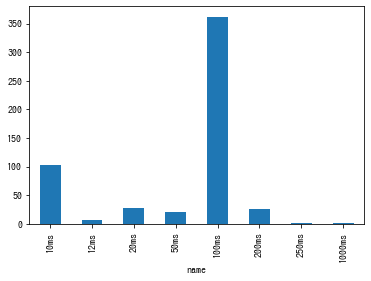

In [16]:
df_bins_sub = df_bins[df_bins["count"] > 0]
df_bins_sub["name"] = ["10ms", "12ms", "20ms", "50ms", "100ms", "200ms",
                      "250ms", "1000ms"]
df_bins_sub.set_index("name", inplace=True)
df_bins_sub["count"].plot(kind="bar");

In [48]:
df_time_diff.head()

,feature,avg_time_diff,med_time_diff
0,3BA12,0.099994,0.099994
1,31007,0.099995,0.100001
2,3C112,0.099898,0.100047
3,3D077,0.098435,0.100027
4,3D052,0.098435,0.100027


###### 値が変化するものに限定

In [49]:
# 変化しない特徴量を除く
# binを指定して、各binに含まれるデータ数をカウント
bins = np.histogram(df_time_diff.loc[df_time_diff.feature.isin(feature_selected),
                                     "med_time_diff"],
                    bins=[0,
                          0.0085, 0.0105, 
                          0.0115, 0.0125, 
                          0.015, 0.025, 
                          0.045, 0.055, 
                          0.095, 0.105, 
                          0.195, 0.205, 
                          0.245, 0.255, 
                          0.995, 1.005])
bins

(array([ 0, 34,  0,  4,  0, 17,  0,  5,  0, 45,  0,  1,  0,  0,  0,  0]),
 array([0.    , 0.0085, 0.0105, 0.0115, 0.0125, 0.015 , 0.025 , 0.045 ,
        0.055 , 0.095 , 0.105 , 0.195 , 0.205 , 0.245 , 0.255 , 0.995 ,
        1.005 ]))

In [50]:
# DataFrameにまとめる
df_bins = pd.DataFrame({"bins_start(inc)":bins[1][:-1], "bins_end(exc)":bins[1][1:],
             "count":bins[0]})
df_bins["ratio"] = df_bins["count"] / df_bins["count"].sum()
df_bins

,bins_start(inc),bins_end(exc),count,ratio
0,0.0000,0.0085,0,0.000000
1,0.0085,0.0105,34,0.320755
2,0.0105,0.0115,0,0.000000
3,0.0115,0.0125,4,0.037736
4,0.0125,0.0150,0,0.000000
5,0.0150,0.0250,17,0.160377
6,0.0250,0.0450,0,0.000000
7,0.0450,0.0550,5,0.047170
8,0.0550,0.0950,0,0.000000
9,0.0950,0.1050,45,0.424528


/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


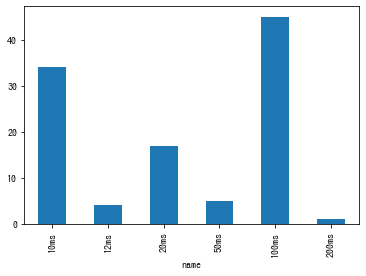

In [52]:
df_bins_sub = df_bins[df_bins["count"] > 0]
df_bins_sub["name"] = ["10ms", "12ms", "20ms", "50ms", "100ms", "200ms"]
df_bins_sub.set_index("name", inplace=True)
df_bins_sub["count"].plot(kind="bar");

#### センサーデータのサンプリング

例えば100Hzの時系列、すなわち10ms間隔の時系列データに変換する場合は、ほとんどのセンサーは計測時間間隔が10msより長いので、アップサンプリングと言える。  
他方、1Hzの時系列、すなわち1s間隔の時系列データに変換する場合は、ほとんどのセンサーは計測時間間隔が1sより短いので、ダウンサンプリングといえる。  
50Hz、すなわち20ms間隔の時系列データに変換する場合は、センサーの計測時間間隔によって、ダウンサンプリングとアップサンプリングが混在することとなる。

ここでは、車両センサーを用いた先行研究で多く見られた、10Hz(100ms間隔)の時系列データを作成する。  
情報ロスを最小にしたい場合も、最も細かい計測時間間隔にあわせて100Hzの時系列データを作成すれば十分であろう。

In [ ]:
df_sel

In [269]:
sampling_unit = 0.1 # 0.1秒間隔で時系列データを作成
sampling_unit_decimal = 1 # 
n_one_file = 6000 # 1ファイルあたりのサンプル数 (600秒 ÷ 0.1秒 = 6000)
intp_precision = 6 # 線形補間時の精度(sql内でroundを使っているので。roundは使わなくてもよい)

In [281]:
sql_intp = """
    with t_orig as (
        select carid
            ,feature
            ,starttime
            ,round(cast(times as real), {sampling_unit_decimal}) as rounded_times
            ,val
        from {table}
        where feature in ({features})
    ),t_grid as (
        select day_of_calendar * {sampling_unit} as time_grid
        from sys_calendar.calendar
        where day_of_calendar between 0 and {n_one_file}
    ),t_downsampled as (
        select carid
            ,feature
            ,starttime
            ,time_grid
            ,avg(val) as avg_val
        from t_grid
        inner join t_orig
        on t_grid.time_grid = t_orig.rounded_times
        group by carid, feature, starttime, time_grid
    ),t_downsampled_set as (
        select carid
            ,feature
            ,starttime
            ,time_grid as curr_time_grid
            ,avg_val
            ,lag(avg_val) over(partition by carid, feature, starttime order by time_grid) as prev_val
            ,lag(time_grid) over(partition by carid, feature, starttime order by time_grid) as prev_time_grid
        from t_downsampled
    )
    select carid
        ,feature
        ,starttime
        ,time_grid
        ,round(prev_val + (avg_val - prev_val) * (time_grid - prev_time_grid) 
                / (curr_time_grid - prev_time_grid),{intp_precision}) as intp_val
    from t_grid
    inner join t_downsampled_set as t_down
    on t_down.prev_time_grid <= t_grid.time_grid and t_grid.time_grid < t_down.curr_time_grid
""".format(table=data_table, features=",".join(["'{}'".format(x) for x in feature_selected[:5]]),
          interim_intp_table=interim_intp_table, n_one_file=n_one_file,
          sampling_unit=sampling_unit, intp_precision=intp_precision,
          sampling_unit_decimal=sampling_unit_decimal)

print(sql_intp)


    with t_orig as (
        select carid
            ,feature
            ,starttime
            ,round(cast(times as real), 1) as rounded_times
            ,val
        from tdsuzuki.CAN_For_Eval
        where feature in ('3C112','12944','11451','1E843','3D025','3D046','1AC41','1AF23','31417','13F47','1B845','1B825','11F53','1EF64','3B957','1AF67','3E206','12013','3D537','3D023','3D100','12033','1E823','31457','1AC27')
    ),t_grid as (
        select day_of_calendar * 0.1 as time_grid
        from sys_calendar.calendar
        where day_of_calendar between 0 and 6000
    ),t_downsampled as (
        select carid
            ,feature
            ,starttime
            ,time_grid
            ,avg(val) as avg_val
        from t_grid
        inner join t_orig
        on t_grid.time_grid = t_orig.rounded_times
        group by carid, feature, starttime, time_grid
    ),t_downsampled_set as (
        select carid
            ,feature
            ,starttime
            ,time_grid as curr_

In [282]:
df_interpol = pd.read_sql_query(sql_intp + "sample 100;", engine)

In [283]:
df_interpol.head()

,carid,feature,starttime,time_grid,intp_val
0,021,3B957,201603210631,351.7,38.431373
1,021,3C112,201603210631,307.7,0.000000
2,021,3C112,201603210631,534.4,0.000000
3,021,1AF23,201603210631,199.8,13.700000
4,021,1EF64,201603210631,270.1,1.800000


中間テーブルを作って、データを保存しておく。

In [251]:
conn = engine.connect() # 接続インスタンス。executeメソッドでクエリを実行できる。
# pd.read_sqlは内部で自動で接続インスタンスを作成、実行後に削除している
# create tableなどはテーブルが返り値として来ないので、conn.executeでクエリを実行する

In [324]:
# 既に同名のテーブルがある場合は、テーブルを削除
# (注1)TeradataはPostgres等と異なり、drop if exists, create or replace tableが使えない
sql_drop = """
drop table {interim_intp_table};""".format(interim_intp_table=interim_intp_table)
res = conn.execute(sql_drop)

In [325]:
# 中間データ用テーブルを作成
sql_create = """
create table {interim_intp_table} (
    carid varchar(3)
    ,feature varchar(5)
    ,starttime bigint
    ,time_grid real
    ,intp_val real
);""".format(interim_intp_table=interim_intp_table)
res = conn.execute(sql_create)

In [326]:
pd.read_sql_query(f"select * from {interim_intp_table}", engine) # 出来たか確認

,carid,feature,starttime,time_grid,intp_val


In [327]:
%%time

# 作ったテーブルにデータをインサート。
sql_intp_insert = f"insert into {interim_intp_table} \n" + sql_intp
conn.execute(sql_intp_insert)

CPU times: user 117 ms, sys: 137 ms, total: 254 ms
Wall time: 1h 9min 50s


In [328]:
# teradataではPostgres/SQLiteのlimitやOracleのwhere rownum <= ~~ の代わりにtopが使える
pd.read_sql_query(f"select top 5 * from {interim_intp_table}", engine)

,carid,feature,starttime,time_grid,intp_val
0,021,11451,2.016032e+11,346.5,1.5
1,021,11451,2.016032e+11,372.4,1.5
2,021,11451,2.016032e+11,350.4,1.5
3,021,11451,2.016032e+11,342.1,1.5
4,021,11451,2.016032e+11,339.1,1.5


In [329]:
pd.read_sql_query(f"select distinct(feature) from {interim_intp_table}", engine)

,feature
0,3C112
1,11F53
2,12944
3,11451
4,1E843
5,3D025
6,1E823
7,1EF64
8,3B957
9,31457


In [330]:
pd.read_sql_query(f"select count(*) from {interim_intp_table}", engine)

,Count(*)
0,146883.0


In [331]:
sql_pivot = """
SELECT *
FROM {interim_intp_table} PIVOT (
    avg(intp_val) as val
    FOR feature
    IN ('12217' as feat_12217, '11947', '1EF61', '1EF37')
    )Tmp
""".format(interim_intp_table=interim_intp_table)
print(sql_pivot)


SELECT *
FROM tdsuzuki.INTERIM_INTERPOLATED PIVOT (
    avg(intp_val) as val
    FOR feature
    IN ('12217' as feat_12217, '11947', '1EF61', '1EF37')
    )Tmp



In [332]:
df_pivot = pd.read_sql_query(sql_pivot, engine)

In [313]:
df_test = pd.read_sql_query("""
select * 
from {data_table}
where feature = '1EF61'
sample 6000
""".format(data_table=data_table), engine)

In [318]:
df_test["times"] = df_test.times.astype(float)
df_test["val"] = df_test.val.astype(float)

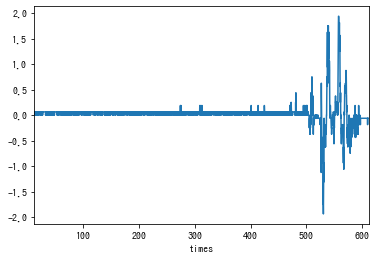

In [319]:
df_test.set_index("times")["val"].plot()

In [333]:
df_pivot.head()

,carid,starttime,time_grid,feat_12217_val,'11947'_val,'1EF61'_val,'1EF37'_val
0,021,2.016032e+11,531.2,None,None,None,None
1,021,2.016032e+11,419.4,None,None,None,None
2,021,2.016032e+11,36.3,None,None,None,None
3,021,2.016032e+11,290.3,None,None,None,None
4,021,2.016032e+11,396.4,None,None,None,None


In [334]:
df_pivot.set_index("time_grid").sort_values(by="time_grid")["'1EF61'_val"].plot()

TypeError: Empty 'DataFrame': no numeric data to plot

### 使用する変数の選択(時系列データ)

トランザクションデータから時系列データとなったので、他の変数との相関係数が計算できる。

まず、各データの様子を掴むため、一部のデータを図示しておく。繰り返しになるが、可視化と、目視による判断/考察はデータ分析において極めて重要である。

In [257]:
# 各センサー、5000点ほど図示
# (注)通常のデータベースではrow_numberで作成した列に対してwhereを使えないものが多い。
#     その場合、with句やsubqueryなどを使用することになるが、
#     Teradataはqualify句を使って、whereのようにフィルタリングを掛けることができる
df_tmp = pd.read_sql_query("""
select a.*, row_number() over (partition by feature order by starttime, time_grid) as i
from {interim_intp_table} as a
qualify i <= 5000;""".format(interim_intp_table=interim_intp_table), engine)

In [ ]:
'11947','12217','1EF37','1EF61','31417'

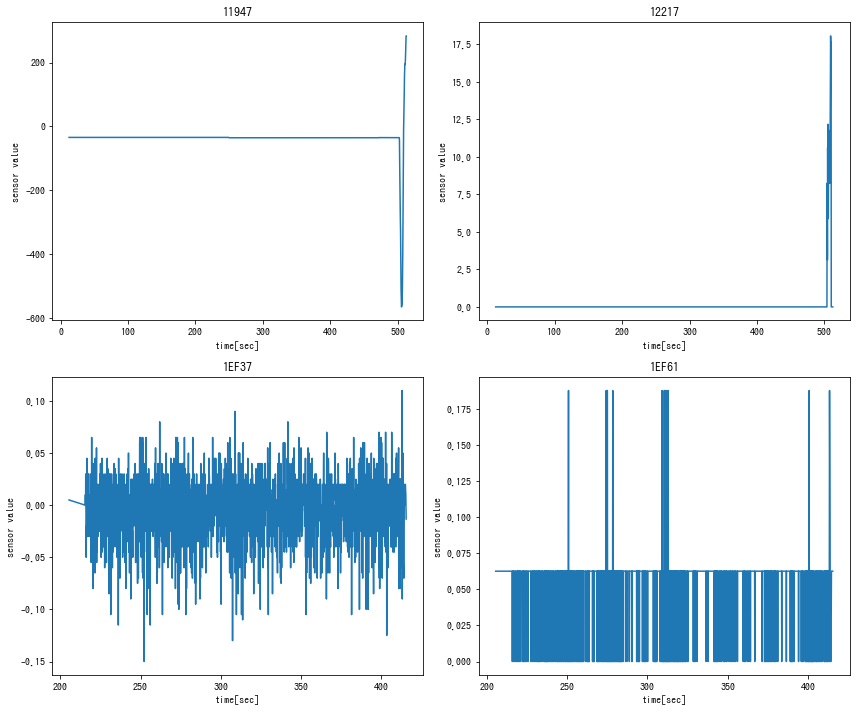

In [258]:
import math
fig = plt.figure(figsize=(12,10))
features = df_tmp.feature.unique()
for i, feature in enumerate(features):
    ax = fig.add_subplot(math.ceil(len(features)/2), 2, i+1)
    tmp = df_tmp.loc[df_tmp.feature==feature]
    ax.plot(tmp.time_grid, tmp.intp_val)
    ax.set(xlabel="time[sec]", ylabel="sensor value", title=feature)

plt.tight_layout()

#### 変数同士の相関

In [202]:
# 変数同士の相関係数の計算。
# (注)corrはANSI SQL2011準拠のピアソンの積率相関係数(つまり、Excelなどと同じ、いわゆる普通の相関係数)
sql_corr = """
select 
    t1.feature as feature_1
    ,t2.feature as feature_2
    ,corr(t1.intp_val, t2.intp_val) as pearson_corr
from
    {interim_intp_table} t1
inner join 
    {interim_intp_table} t2
on  
    t1.time_grid = t2.time_grid 
    and t1.starttime = t2.starttime
    and t1.carid = t2.carid 
    and t1.feature < t2.feature -- 文字列の場合、辞書で大小が決まる。これで二重に相関を計算することを防ぐ
group by
    feature_1, feature_2
""".format(interim_intp_table=interim_intp_table)

In [203]:
print(sql_corr)


select 
    t1.feature as feature_1
    ,t2.feature as feature_2
    ,corr(t1.intp_val, t2.intp_val) as pearson_corr
from
    tdsuzuki.INTERIM_INTERPOLATED t1
inner join 
    tdsuzuki.INTERIM_INTERPOLATED t2
on  
    t1.time_grid = t2.time_grid 
    and t1.starttime = t2.starttime
    and t1.carid = t2.carid 
    and t1.feature < t2.feature -- 文字列の場合、辞書で大小が決まる。これで二重に相関を計算することを防ぐ
group by
    feature_1, feature_2



In [204]:
%%time
df_corr = pd.read_sql_query(sql_corr, engine)

CPU times: user 7.24 ms, sys: 3.35 ms, total: 10.6 ms
Wall time: 45 s


In [216]:
df_corr.head()

,feature_1,feature_2,pearson_corr
0,1EF37,1EF61,0.848550
1,11947,1EF61,0.411028
2,11947,1EF37,0.652357
3,11947,31417,0.209031
4,1EF37,31417,0.133235


In [205]:
df_corr.loc[df_corr.pearson_corr.abs() > 0.9] # 相関係数の絶対値が0.9以上のペア

,feature_1,feature_2,pearson_corr


非定常な時系列については、そのまま相関係数を取ると、高めの数字がでやすくなってしまう。  
(例え全く関係のない時系列でも、高い相関が出てしまうことがある。)  
そのような場合は、一度差分を取ってから相関係数を計算すると良い。(ほとんどの場合、非定常な時系列は一回差分を取れば、定常な時系列となる。)

In [209]:
# 変数の差分同士の相関係数の計算。
sql_diff_corr = """
with t_diff as (
    select
        carid
        ,starttime
        ,time_grid
        ,feature
        ,lag(intp_val) over(partition by carid, starttime, feature order by time_grid) as prev_val
        ,intp_val - prev_val as val_diff
    from {interim_intp_table}
)

select 
    t1.feature as feature_1
    ,t2.feature as feature_2
    ,corr(t1.val_diff, t2.val_diff) as pearson_corr
from
    t_diff t1
inner join 
    t_diff t2
on  
    t1.time_grid = t2.time_grid 
    and t1.starttime = t2.starttime
    and t1.carid = t2.carid 
    and t1.feature < t2.feature -- 文字列の場合、辞書で大小が決まる。これで二重に相関を計算することを防ぐ
group by
    feature_1, feature_2
""".format(interim_intp_table=interim_intp_table)

In [210]:
%%time
df_diff_corr = pd.read_sql_query(sql_diff_corr, engine)

CPU times: user 7.16 ms, sys: 3.97 ms, total: 11.1 ms
Wall time: 54.4 s


In [215]:
df_diff_corr.head()

,feature_1,feature_2,pearson_corr
0,1EF37,1EF61,0.161471
1,11947,1EF61,0.173411
2,11947,1EF37,0.477559
3,11947,31417,0.025863
4,1EF37,31417,-0.091734


In [214]:
df_diff_corr.loc[df_diff_corr.pearson_corr.abs() > 0.9] # 相関係数の絶対値が0.9以上のペア

,feature_1,feature_2,pearson_corr


#### 自己相関

In [221]:
# lag=1~40までの自己相関係数の計算。 corrとlagと使用: 
# (注)corrはANSI準拠のピアソンの積率相関係数(つまり、Excelなどと同じ、普通の相関係数)

lag_part = ""
corr_part = ""
for i in range(1, 41): # 1,2,...,40
    lag_part += """
        ,lag(intp_val, {i}) over(partition by carid, starttime, 
             feature order by time_grid) as intp_val_lag_{i}""".format(i=i)
    corr_part += """
        ,corr(intp_val, intp_val_lag_{i}) as autocorr_lag_{i}""".format(i=i)
    
sql_autocorr = """
with t_lag as (
    select 
        feature
        ,intp_val
        {lag_part}
    from {interim_intp_table}
)
select 
    feature
    {corr_part}
from t_lag
group by feature
""".format(interim_intp_table=interim_intp_table, lag_part=lag_part,
          corr_part=corr_part)

print(sql_autocorr)


with t_lag as (
    select 
        feature
        ,intp_val
        
        ,lag(intp_val, 1) over(partition by carid, starttime, 
             feature order by time_grid) as intp_val_lag_1
        ,lag(intp_val, 2) over(partition by carid, starttime, 
             feature order by time_grid) as intp_val_lag_2
        ,lag(intp_val, 3) over(partition by carid, starttime, 
             feature order by time_grid) as intp_val_lag_3
        ,lag(intp_val, 4) over(partition by carid, starttime, 
             feature order by time_grid) as intp_val_lag_4
        ,lag(intp_val, 5) over(partition by carid, starttime, 
             feature order by time_grid) as intp_val_lag_5
        ,lag(intp_val, 6) over(partition by carid, starttime, 
             feature order by time_grid) as intp_val_lag_6
        ,lag(intp_val, 7) over(partition by carid, starttime, 
             feature order by time_grid) as intp_val_lag_7
        ,lag(intp_val, 8) over(partition by carid, starttime, 
           

In [222]:
%%time
df_autocorr = pd.read_sql_query(sql_autocorr, engine)

CPU times: user 20.2 ms, sys: 1.99 ms, total: 22.2 ms
Wall time: 3.93 s


In [223]:
df_autocorr

,feature,autocorr_lag_1,autocorr_lag_2,autocorr_lag_3,autocorr_lag_4,autocorr_lag_5,autocorr_lag_6,autocorr_lag_7,autocorr_lag_8,autocorr_lag_9,...,autocorr_lag_31,autocorr_lag_32,autocorr_lag_33,autocorr_lag_34,autocorr_lag_35,autocorr_lag_36,autocorr_lag_37,autocorr_lag_38,autocorr_lag_39,autocorr_lag_40
0,11947,0.999048,0.996261,0.991767,0.985666,0.978023,0.968898,0.958370,0.946523,0.933444,...,0.476517,0.454243,0.432249,0.410561,0.389200,0.368186,0.347539,0.327273,0.307399,0.287921
1,1EF61,0.957733,0.915826,0.901105,0.894616,0.881744,0.866315,0.847638,0.821463,0.795229,...,0.214063,0.193125,0.172097,0.149620,0.128055,0.111466,0.096843,0.083277,0.066492,0.048369
2,1EF37,0.997205,0.991644,0.983938,0.973420,0.960541,0.945043,0.927399,0.907774,0.886430,...,0.287240,0.264389,0.242320,0.221178,0.201081,0.181965,0.163844,0.146645,0.130363,0.114935
3,31417,0.999958,0.999836,0.999640,0.999371,0.999030,0.998619,0.998138,0.997591,0.996979,...,0.970694,0.969048,0.967375,0.965675,0.963952,0.962207,0.960442,0.958658,0.956858,0.955043
4,12217,0.994036,0.982893,0.971997,0.961459,0.950366,0.938770,0.926603,0.913900,0.901868,...,0.738201,0.732756,0.727610,0.722638,0.717873,0.712859,0.707082,0.700387,0.693132,0.686097


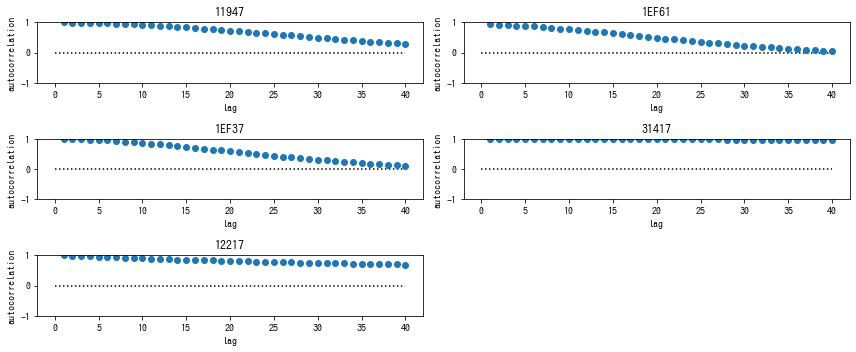

In [231]:
fig = plt.figure(figsize=(12,5))
for i,row in df_autocorr.iterrows():
    ax = fig.add_subplot(math.ceil(df_autocorr.shape[0]/2), 2, i+1)
    ax.plot(range(1,41), row.values[1:], "o")
    ax.hlines(0, 0, 40, linestyle=":")
    ax.set(xlabel="lag", ylabel="autocorrelation", title=row.values[0],
          ylim=(-1,1))
    
plt.tight_layout()

Pythonでの分析結果を応用して、自己相関係数が高いものを除外する。

また、他の変数と相関係数が高いペアの片方を除外する。

### ダウンサンプリング

In [ ]:
# carid単位

In [ ]:
# 1秒単位

In [ ]:
# 日付単位

In [ ]:
# 1時間単位

### 使用するクラスター数と変数を決定

### クラスタリングを実行

### クラスターを解釈

In [ ]:
# 2次元プロット

In [ ]:
# 中央値